In [1]:
from ssh_pymongo import MongoSession
import matplotlib.pyplot as plt
from collections import defaultdict
from datetime import datetime
import pandas as pd
import os

# Initialize MongoDB instance
client = MongoSession(
            str(os.getenv("REMOTE_SERVER")),
            port=22,
            user=str(os.getenv("SSH_USER")),
            password=str(os.getenv("SSH_AUTHENTICATION")),
            uri=str(os.getenv("MONGOSTRING")))
        
database = client.connection["traffic_analysis"]
collection = database['vehicle']

# Retrieve all documents
all_documents = collection.find()  # Empty query to fetch all

# Count vehicles per timestamp
vehicle_counts = defaultdict(int)

In [ ]:
pipeline = [
    # {
    #     '$match': {
    #         'dmy': '*_10_24',
    #         # 'confidence' : {"$gte", 0.70}
    #     }},
        {'$group': {
            '_id': {
                # "class_id" : "$class_id",
                "class_name" : "$class_name",
                # "confidence": "$confidence",
                'time': { '$substr': ['$time_stamp', 0, 14] },
            },
            # "confidence": "$confidence",
            'count': {"$sum" : 1}
        }
    },
    {"$sort": {"_id.dmy":1}}
]

results = list(collection.aggregate(pipeline))

class_name    object
time          object
count          int64
dtype: object
0       16
1       07
2       10
3       10
4       11
        ..
2368    13
2369    11
2370    08
2371    11
2372    12
Name: time, Length: 2373, dtype: object
class_name  bicycle  bird   bus     car  dog  person  truck
time                                                       
02              NaN   NaN   NaN     1.0  NaN     NaN    NaN
06              NaN   NaN   NaN     1.0  NaN     NaN    NaN
07              NaN   NaN   2.0   781.0  NaN   248.0    NaN
08            195.0   NaN  49.0  2642.0  2.0  1486.0   11.0
09            616.0   1.0   1.0   769.0  1.0  1066.0   17.0
class_name
bicycle    float64
bird       float64
bus        float64
car        float64
dog        float64
person     float64
truck      float64
dtype: object


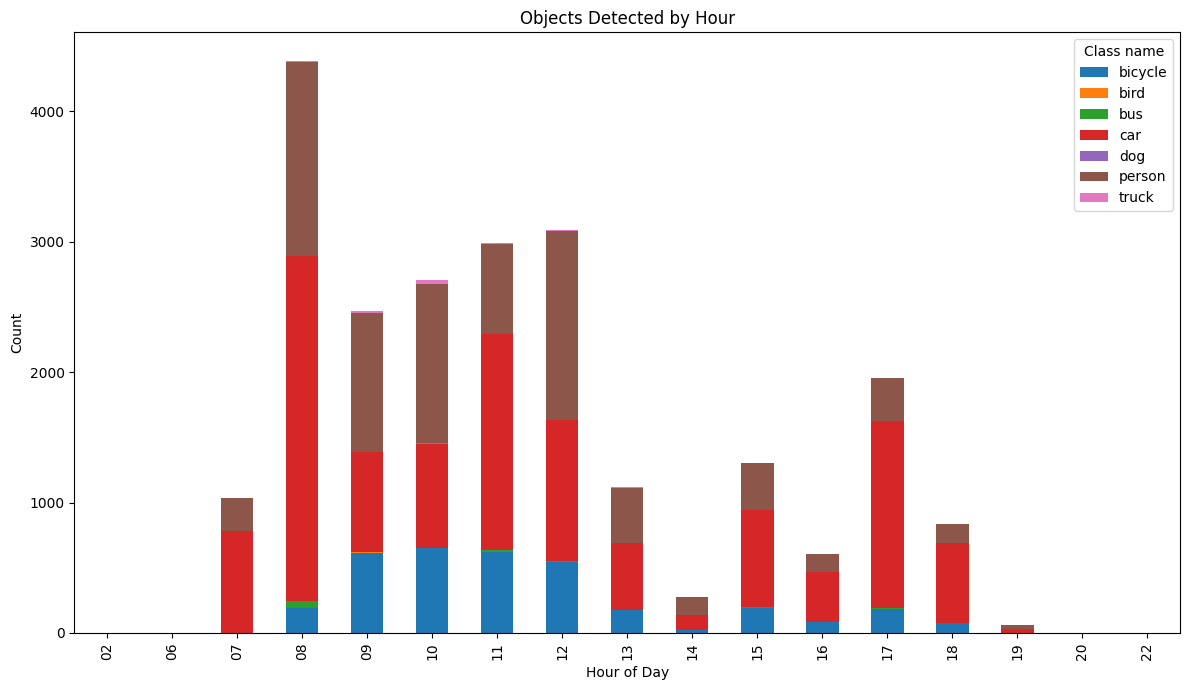

In [24]:
if not results:
    print("No data found with the given criteria.")
else:
    # Process aggregation results into a DataFrame
    data = {
        'class_name': [], 
        'time': [], 
        'count': []
    }
    
    for result in results:
        data['class_name'].append(result['_id']['class_name'])
        data['time'].append(result['_id']['time'].split('_')[-2])
        data['count'].append(result['count'])
    
    df = pd.DataFrame(data)
    
    # Verify data types
    print(df.dtypes)
    print(df['time'])
    
    # Ensure 'class_id' and 'count' are numeric
    # df['class_name'] = pd.to_numeric(df['class_name'], errors='coerce')
    df['count'] = pd.to_numeric(df['count'], errors='coerce')
    
    # Check for NaNs after conversion
    if df[['count']].isnull().any().any():
        print("Warning: NaN values found after conversion. Check your data.")
    
    # Pivot the DataFrame for plotting
    pivot_df = df.pivot_table(values='count', index='time', columns='class_name', aggfunc='sum')
    
    # Display pivot_df
    print(pivot_df.head())
    print(pivot_df.dtypes)
    
    # Ensure pivot_df contains numeric data
    if pivot_df.empty:
        print("Pivot DataFrame is empty. No data to plot.")
    else:
        # Plotting
        pivot_df.plot(kind='bar', stacked=True, figsize=(12, 7))
        plt.title('Objects Detected by Hour')
        plt.xlabel('Hour of Day')
        plt.ylabel('Count')
        plt.legend(title='Class name')
        plt.tight_layout()
        plt.show()

In [10]:
model_pipe = [
    {
        '$match': {
            'confidence' : { '$gt' : .75}
        }
        },
        {
            '$group': {
            '_id': {
                "class_name" : "$class_name",
            },
            'count': {"$sum" : 1},
            'avg_confi' : {"$avg" : '$confidence'},
        }
    }
]

results_model = list(collection.aggregate(model_pipe))

class_name     object
avg           float64
count           int64
dtype: object
class_name   bicycle      bird       bus  car       dog  person     truck
count                                                                    
2                NaN  0.818115       NaN  NaN       NaN     NaN       NaN
13               NaN       NaN       NaN  NaN  0.839055     NaN       NaN
83               NaN       NaN       NaN  NaN       NaN     NaN  0.835767
85               NaN       NaN  0.878941  NaN       NaN     NaN       NaN
3355        0.813278       NaN       NaN  NaN       NaN     NaN       NaN
class_name
bicycle    float64
bird       float64
bus        float64
car        float64
dog        float64
person     float64
truck      float64
dtype: object


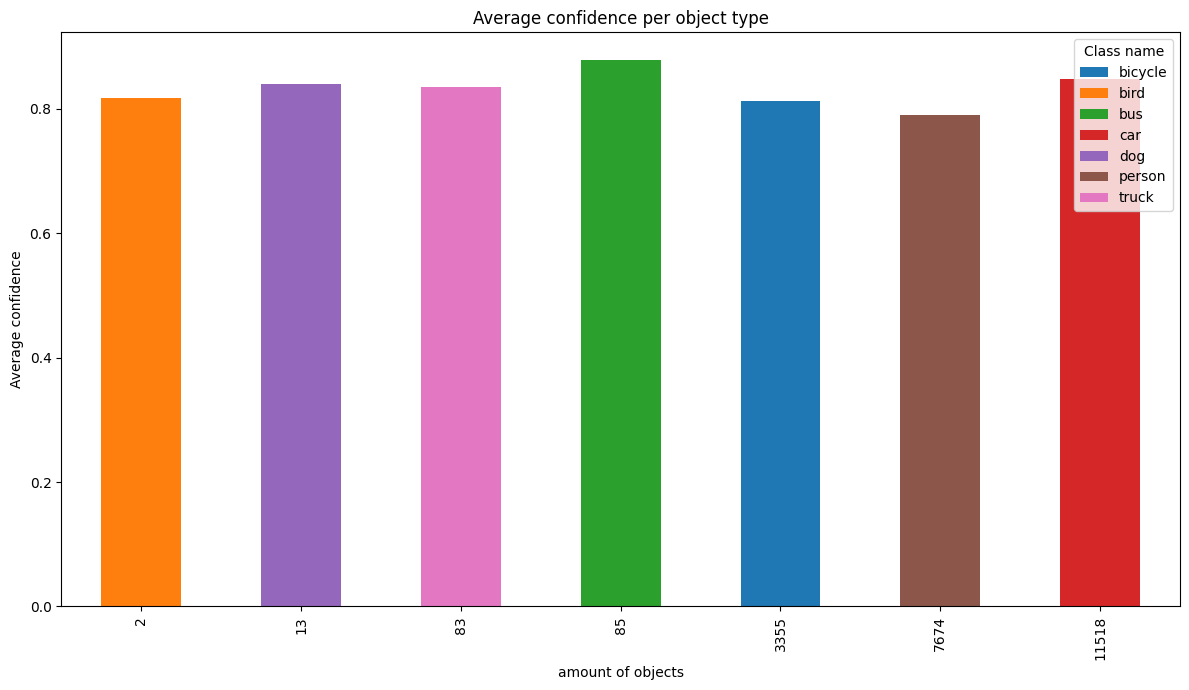

In [16]:
if not results_model:
    print("No data found with the given criteria.")
else:
    # Process aggregation results into a DataFrame
    data = {
        'class_name': [], 
        'avg': [],
        'count': []
    }
    
    for result in results_model:
        data['class_name'].append(result['_id']['class_name'])
        data['avg'].append(result['avg_confi'])
        data['count'].append(result['count'])
    
    df = pd.DataFrame(data)
    
    # Verify data types
    print(df.dtypes)
    
    # Ensure 'class_id' and 'count' are numeric
    df['avg'] = pd.to_numeric(df['avg'], errors='coerce')
    df['count'] = pd.to_numeric(df['count'], errors='coerce')
    
    # Check for NaNs after conversion
    if df[['count', 'avg']].isnull().any().any():
        print("Warning: NaN values found after conversion. Check your data.")
    
    # Pivot the DataFrame for plotting
    pivot_df = df.pivot_table(values='avg', index='count', columns='class_name', aggfunc='sum')
    
    # Display pivot_df
    print(pivot_df.head())
    print(pivot_df.dtypes)
    
    # Ensure pivot_df contains numeric data
    if pivot_df.empty:
        print("Pivot DataFrame is empty. No data to plot.")
    else:
        # Plotting
        pivot_df.plot(kind='bar', stacked=True, figsize=(12, 7))
        plt.title('Average confidence per object type')
        plt.xlabel('amount of objects')
        plt.ylabel('Average confidence')
        plt.legend(title='Class name')
        plt.tight_layout()
        plt.show()